In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from statistics import mode

import scipy.spatial as spatial
from scipy.spatial import Voronoi, voronoi_plot_2d, cKDTree
from scipy.spatial.distance import cdist

path_base = "./IMG/"

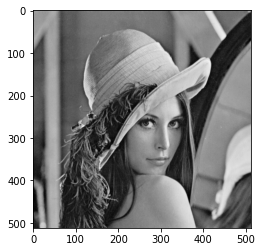

In [2]:
lena = cv2.imread(path_base + "lena_gray_512.tif", 0)
plt.imshow(lena, "gray")

In [13]:
def Lloyd_2D(input_vectors, N):
  codebook_vectors = np.random.rand(N, 2)
  codebook = dict(list(enumerate(codebook_vectors)))

  display_voronoi_diagram(codebook_vectors, input_vectors)
  return Lloyd_2D_R(codebook, input_vectors, N)

def Lloyd_2D_R(codebook, input_vectors, N):
  codebook_vectors = list(codebook.values())
  new_codebook_vectors = compute_new_vectors_2d(codebook_vectors, input_vectors, N)
  display_voronoi_diagram(new_codebook_vectors, input_vectors)

  new_codebook = dict(list(enumerate(new_codebook_vectors)))

  if distorsion(codebook_vectors, new_codebook_vectors) > 1e-8:
    return Lloyd_2D_R(new_codebook, input_vectors, N)
  else:
    return new_codebook

def display_voronoi_diagram(codebook_vectors, input_vectors):
  vor = Voronoi(codebook_vectors)

  fig,ax = plt.subplots(1,1,figsize=(5,5))
  voronoi_plot_2d(vor, ax, show_vertices = False)
  plt.scatter(input_vectors[:,0], input_vectors[:,1],color = 'r')
  plt.xlim([0, 1])
  plt.ylim([0, 1])

def compute_new_vectors_2d(codebook_vectors,input_vectors, N):
  voronoi_kdtree = cKDTree(codebook_vectors)
  input_vectors_dist, input_vectors_regions = voronoi_kdtree.query(input_vectors)

  new_codebook_vectors = np.array(codebook_vectors.copy())

  for i in range(N):
    indexes = np.where(input_vectors_regions==i)
    current_region_vectors = [input_vectors[idx] for idx in indexes][0]
    if len(current_region_vectors) > 0:
      avg = np.mean(current_region_vectors, axis=0)
      new_codebook_vectors[i] = avg
    else:
      #new_codebook_vectors[i] = codebook_vectors[i] #Les vecteurs ne bougent pas si leur région est vide
      #new_codebook_vectors[i] = codebook_vectors[np.random.randint(0, len(codebook_vectors))] #Les vecteurs bougent à un endroit aléatoire
      new_codebook_vectors[i] = codebook_vectors[most_populated_region(input_vectors_regions)] #Les vecteurs prennent la position du vecteur dont la région est la plus pleine
      
    voronoi_kdtree = cKDTree(new_codebook_vectors)
    input_vectors_dist, input_vectors_regions = voronoi_kdtree.query(input_vectors)

  return new_codebook_vectors

def distorsion(old_vectors, new_vectors):
  #return np.square(np.subtract(old_vectors, new_vectors)).mean() #Mean Squared Error
  return np.sqrt(np.sum(np.square(old_vectors - new_vectors))) #Distance euclidienne

def most_populated_region(input_vectors_regions):
  return mode(input_vectors_regions)


{0: array([0.17664293, 0.84363484]),
 1: array([0.80529101, 0.10095675]),
 2: array([0.33384584, 0.65371102]),
 3: array([0.99725228, 0.02863448]),
 4: array([0.44439916, 0.56909424]),
 5: array([0.7613203 , 0.35720541]),
 6: array([0.88617736, 0.10399755]),
 7: array([0.77026321, 0.24094118]),
 8: array([0.35861677, 0.73524665]),
 9: array([0.65068294, 0.30987524]),
 10: array([0.02652077, 0.97557481]),
 11: array([0.21431774, 0.72278382]),
 12: array([0.60775034, 0.41281073]),
 13: array([0.57502381, 0.49535068]),
 14: array([0.0906172 , 0.87351235]),
 15: array([0.94428805, 0.07526161])}

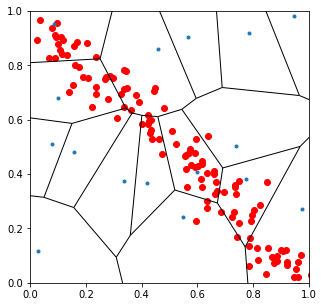

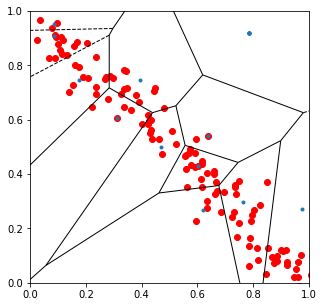

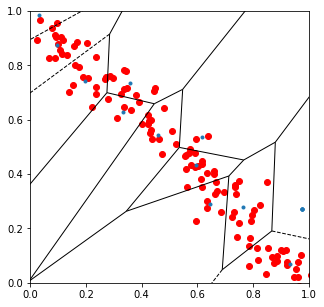

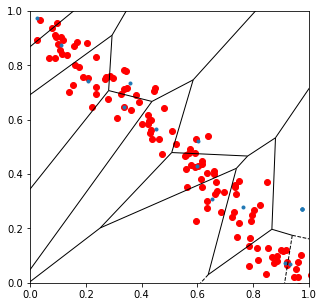

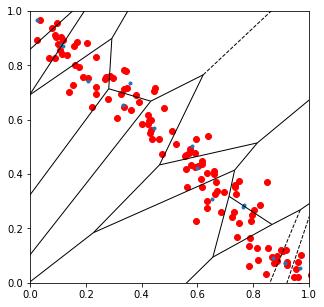

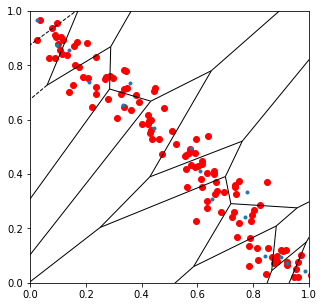

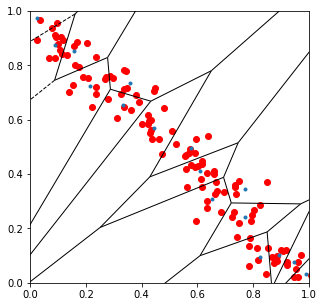

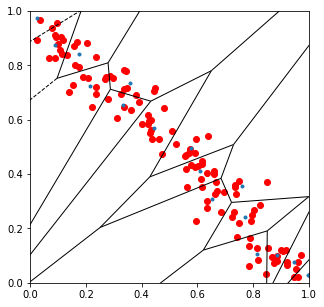

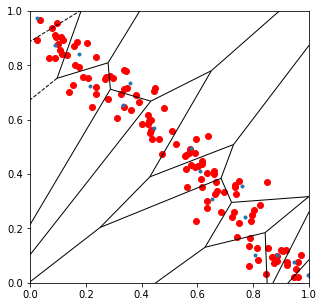

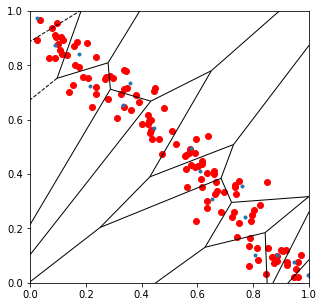

In [14]:
vectors = []
n = 128
for i in range(n):
    vectors.append([1-i/n + np.random.normal()/20, i/n + np.random.normal()/20])

vectors = np.array(vectors)

N = 16

Lloyd_2D(vectors, N)

{0: array([0.56077016, 0.93191967]),
 1: array([0.76345148, 0.59031604]),
 2: array([0.10123034, 0.26026624]),
 3: array([0.53010019, 0.02069811])}

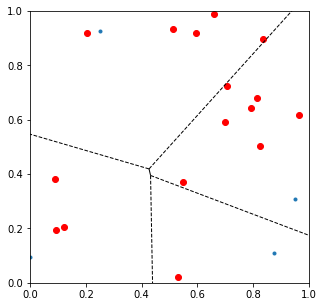

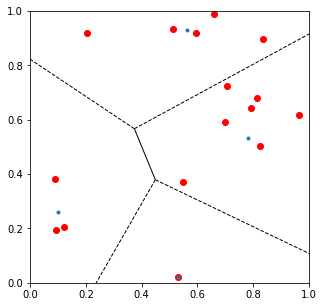

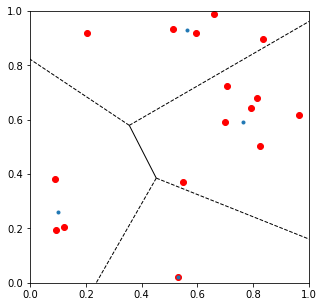

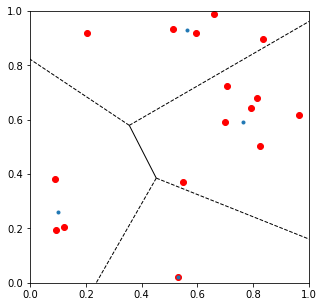

In [51]:
vectors = np.random.rand(16, 2)
N = 4

Lloyd_2D(vectors, N)

In [17]:
def Lloyd_img(img, N, block_size):
  vect_dim = block_size[0] * block_size[1]
  input_vectors = extract_input_vectors(img, block_size)
  codebook_vectors = np.random.rand(N, vect_dim) * 255
  codebook = dict(list(enumerate(codebook_vectors)))

  return Lloyd_img_R(codebook, input_vectors, N, vect_dim)

def Lloyd_img_R(codebook, input_vectors, N, vect_dim):
  codebook_vectors = list(codebook.values())
  new_codebook_vectors = compute_new_vectors_img(codebook_vectors, input_vectors, vect_dim, N)
  new_codebook = dict(list(enumerate(new_codebook_vectors)))

  if distorsion(codebook_vectors, new_codebook_vectors) > 1e-8:
    return Lloyd_img_R(new_codebook, input_vectors, N, vect_dim)
  else:
    return new_codebook

def compute_new_vectors_img(codebook_vectors,input_vectors, vect_dim, N):
  voronoi_kdtree = cKDTree(codebook_vectors)
  input_vectors_dist, input_vectors_regions = voronoi_kdtree.query(input_vectors)
  new_codebook_vectors = np.array(codebook_vectors.copy())

  for i in range(N):
    indexes = np.where(input_vectors_regions==i)
    current_region_vectors = [input_vectors[idx] for idx in indexes[0]]
    if len(current_region_vectors) > 0:
      avg = np.mean(current_region_vectors, axis=0)
      new_codebook_vectors[i] = avg
    else:
      #new_codebook_vectors[i] = codebook_vectors[i]
      #new_codebook_vectors[i] = codebook_vectors[np.random.randint(0, len(codebook_vectors))]
      new_codebook_vectors[i] = codebook_vectors[most_populated_region(input_vectors_regions)]

    voronoi_kdtree = cKDTree(new_codebook_vectors)
    input_vectors_dist, input_vectors_regions = voronoi_kdtree.query(input_vectors)

  return new_codebook_vectors

def extract_input_vectors(arr, block_size):
    nrows, ncols = block_size
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    blocks = arr.reshape(h//nrows, nrows, -1, ncols).swapaxes(1,2).reshape(-1, nrows, ncols)
    vectors = [block.flatten() for block in blocks]
    return vectors

In [18]:
def encode(img, codebook):
  vect_dim = len(list(codebook.values())[0])
  nblock = int(np.sqrt(vect_dim))
  block_size = (nblock, nblock)
  input_vectors = extract_input_vectors(img,block_size)

  all_distances = min_distance(input_vectors, codebook)

  rows, cols = img.shape
  img_encoded = np.reshape([np.argmin(distances) for distances in all_distances], (int(rows/nblock), int(cols/nblock)))
  return img_encoded

def min_distance(input_vector, codebook):
  codebook_vectors = list(codebook.values())
  return cdist(input_vector, codebook_vectors)

In [20]:
def decode(encoded_img, codebook):
  vect_dim = len(list(codebook.values())[0])
  nblock = int(np.sqrt(vect_dim))
  block_size = (nblock, nblock)

  blocks = []
  rows, cols = encoded_img.shape

  for i in range(rows):
    for j in range(cols):
      block = codebook[encoded_img[i,j]].reshape(block_size)
      blocks.append(np.array(block))

  decoded_img = reconstruct_image(np.array(blocks), (rows*nblock, cols*nblock))
  return decoded_img

def reconstruct_image(arr, block_size):
    h, w = block_size
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols).swapaxes(1,2).reshape(h, w))

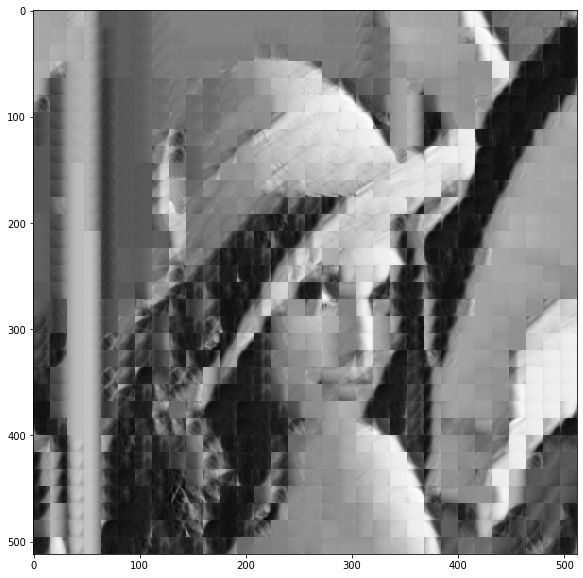

In [27]:
N = 128
block_size = (16,16)

codebook_lena = Lloyd_img(lena, N, block_size) #Optimized codebook

lena_encoded = encode(lena, codebook_lena)

lena_decoded = decode(lena_encoded, codebook_lena)
plt.figure(figsize=(10,10))
plt.imshow(lena_decoded, "gray")

0 / 7  Duration = 0.7390522956848145


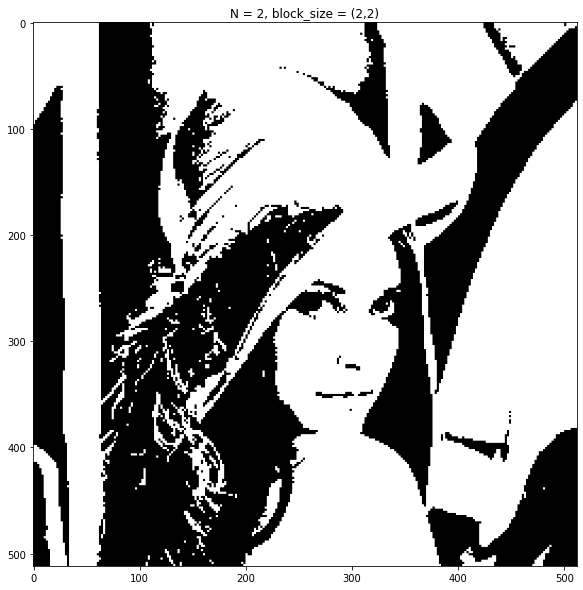

0 / 7  Duration = 0.34879088401794434


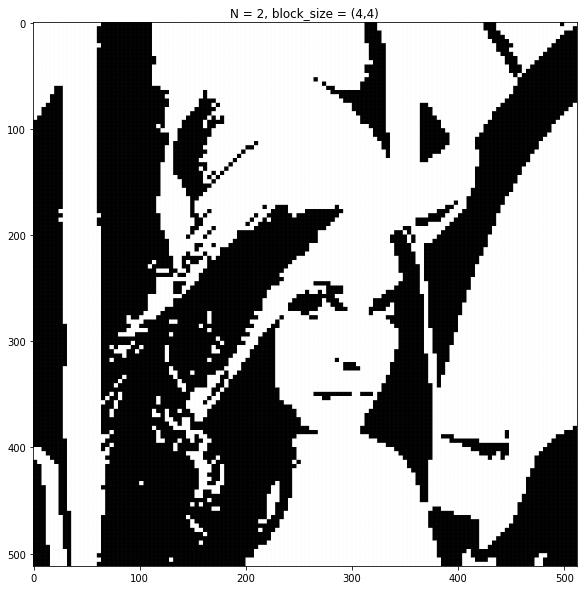

0 / 7  Duration = 0.15929508209228516


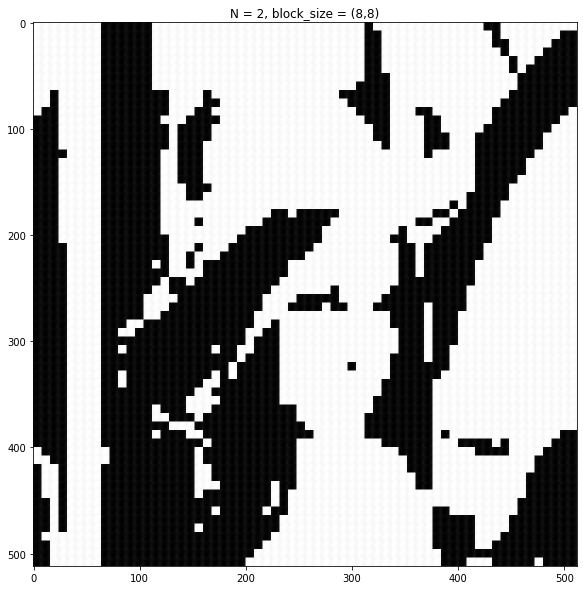

1 / 7  Duration = 3.449867010116577


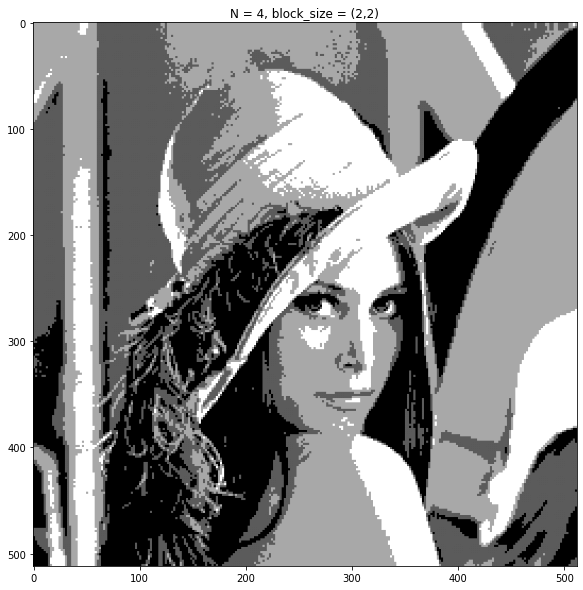

1 / 7  Duration = 1.3394083976745605


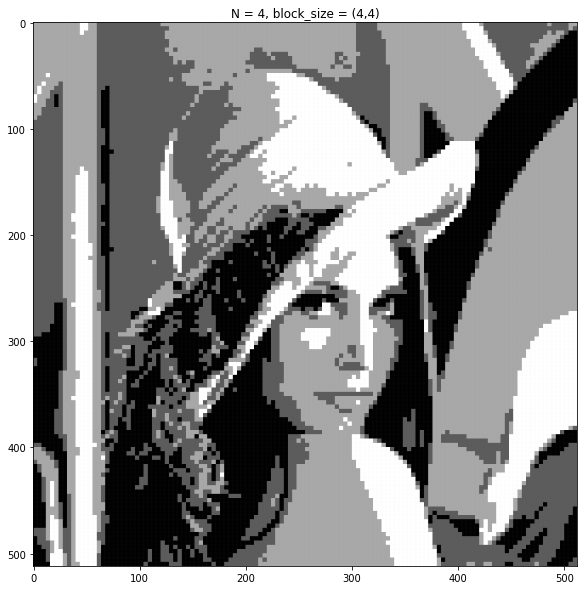

1 / 7  Duration = 0.3274679183959961


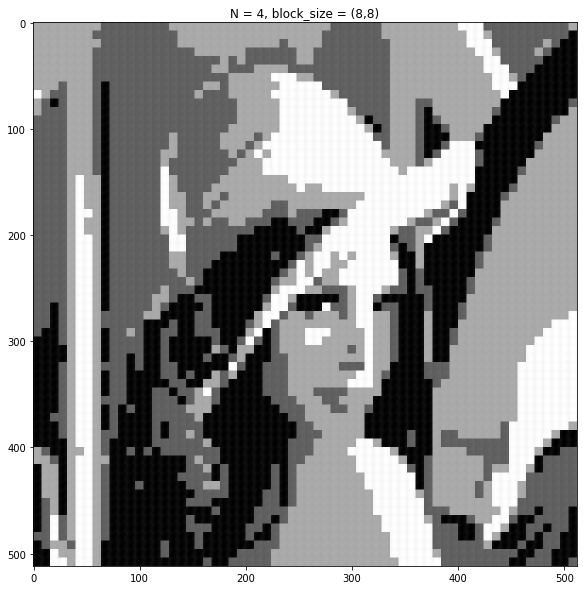

2 / 7  Duration = 31.31023120880127


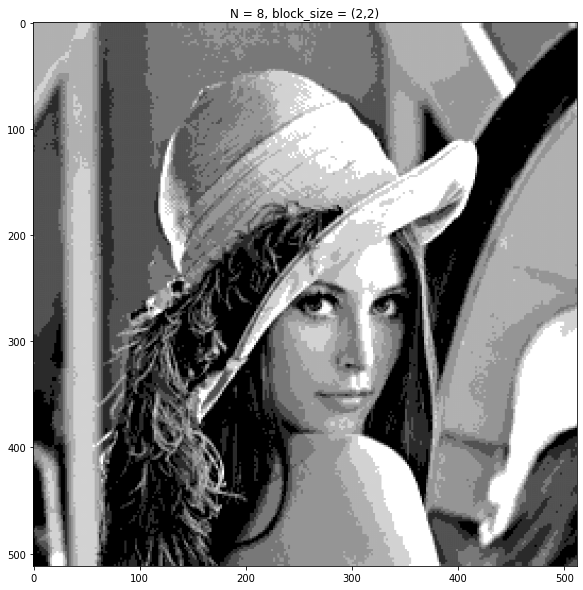

2 / 7  Duration = 4.518367528915405


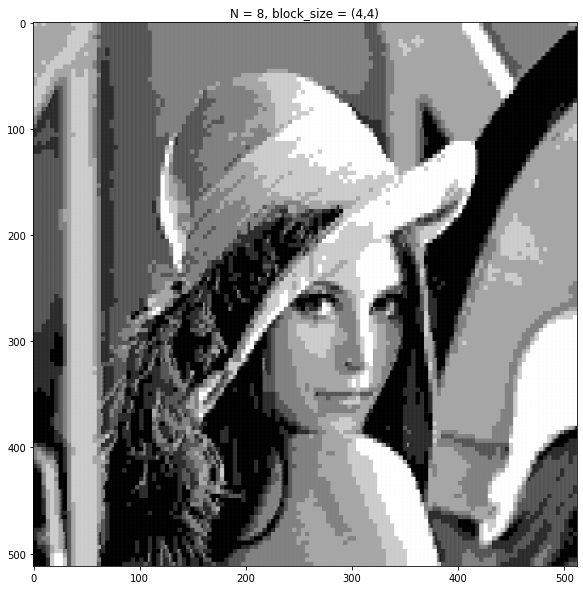

2 / 7  Duration = 2.71490740776062


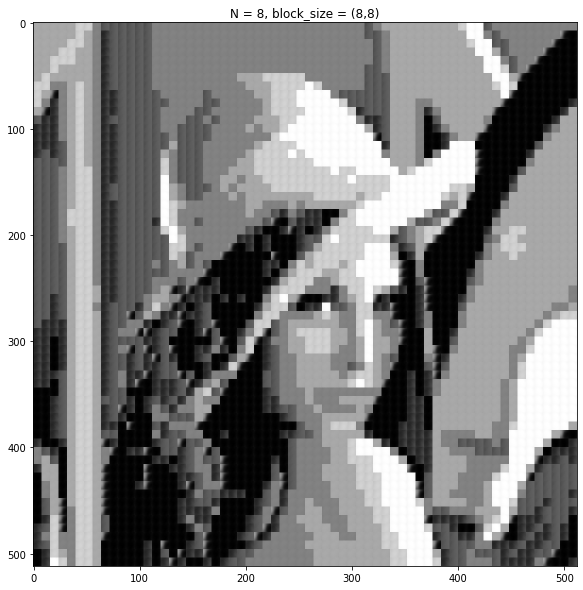

3 / 7  Duration = 42.93751764297485


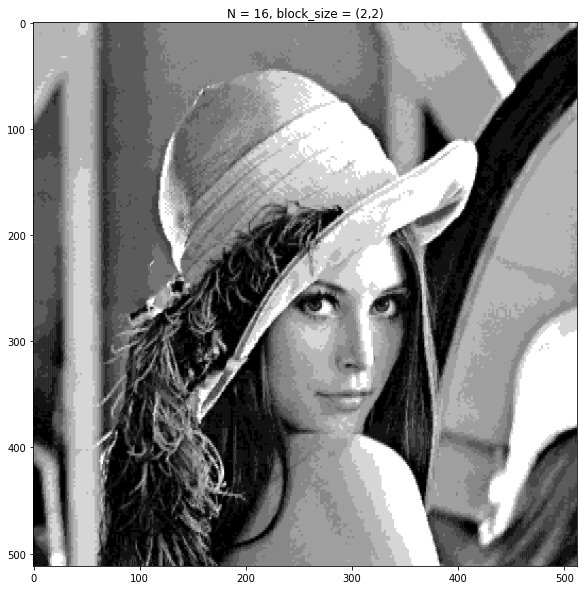

3 / 7  Duration = 9.18764042854309


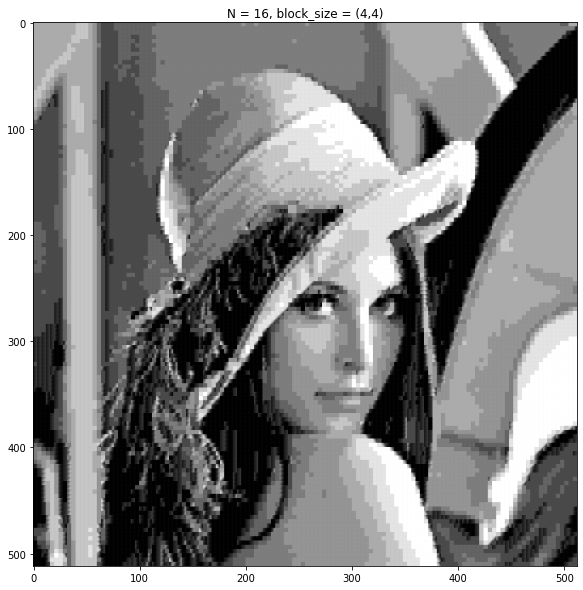

3 / 7  Duration = 2.7211811542510986


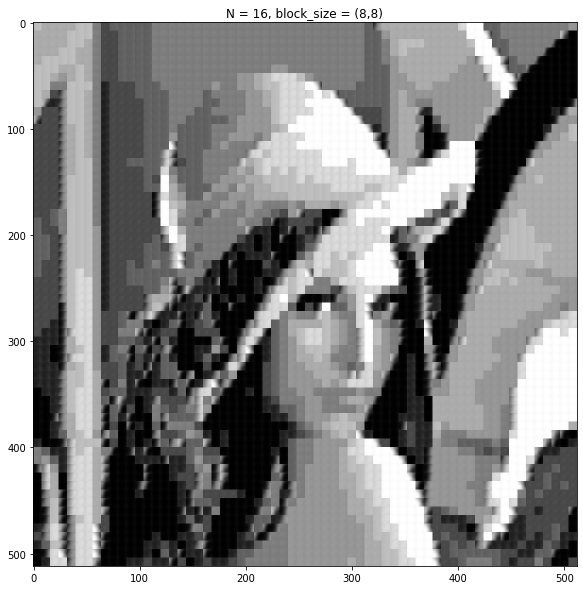

4 / 7  Duration = 192.10312581062317


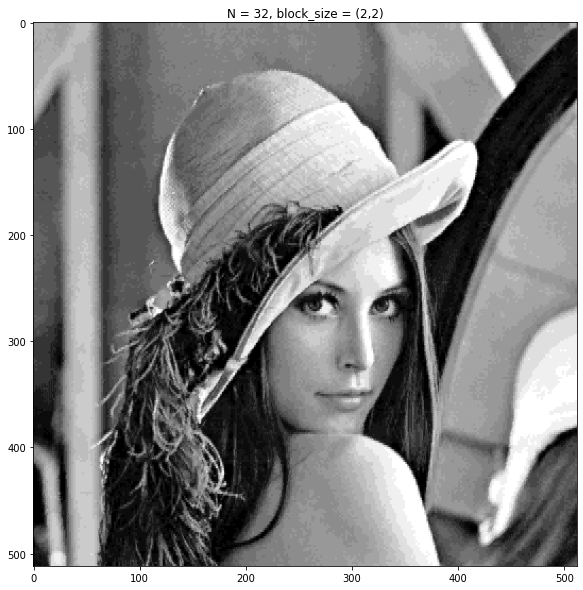

4 / 7  Duration = 35.947153091430664


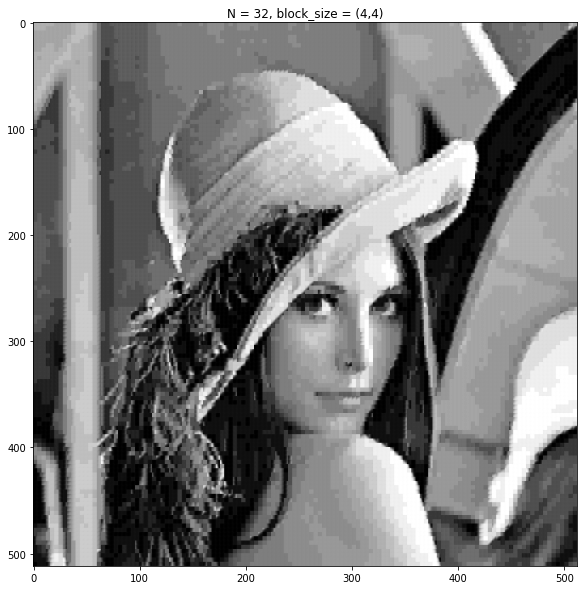

4 / 7  Duration = 21.467772960662842


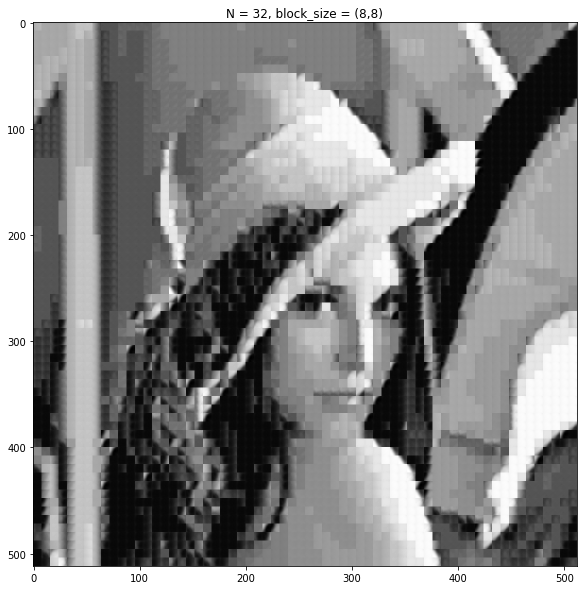

5 / 7  Duration = 704.9695405960083


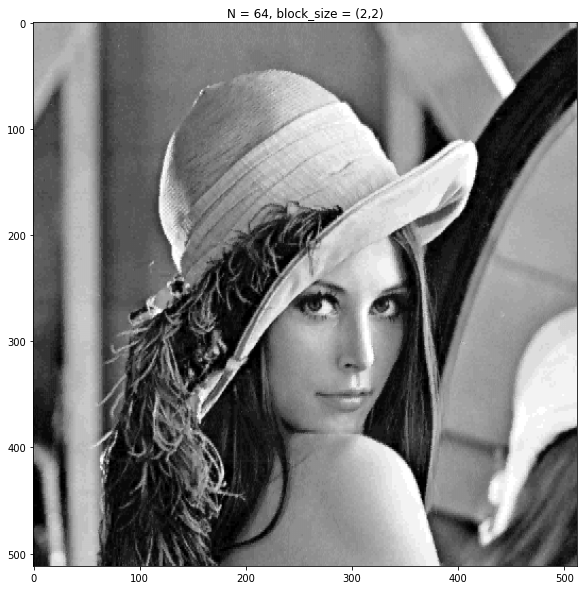

5 / 7  Duration = 66.17374229431152


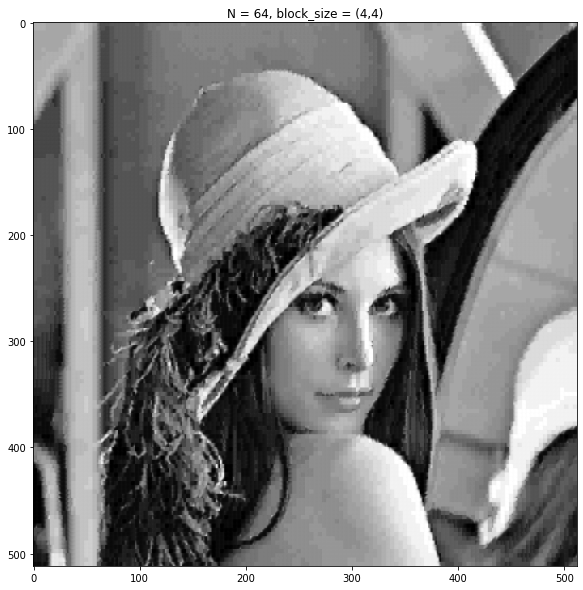

5 / 7  Duration = 31.232876539230347


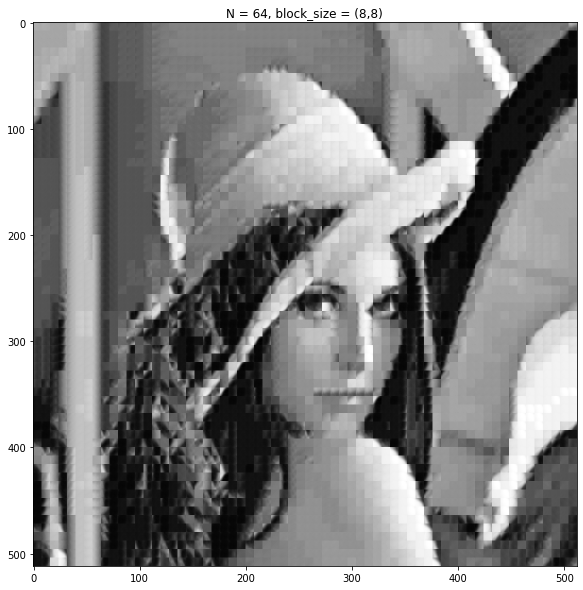

6 / 7  Duration = 862.7432029247284


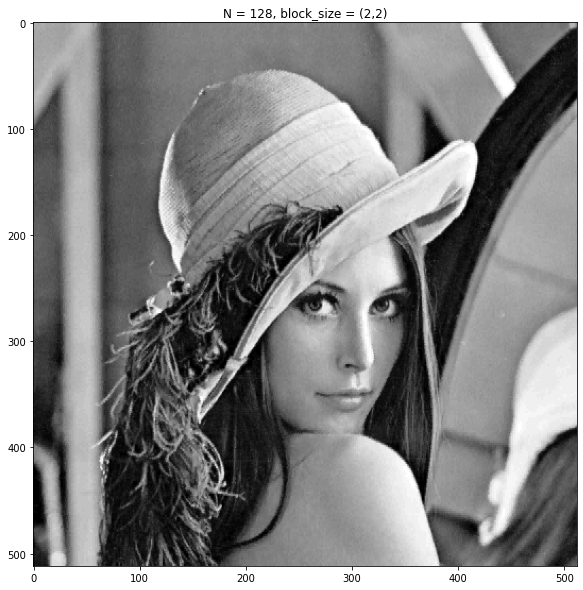

6 / 7  Duration = 273.6348555088043


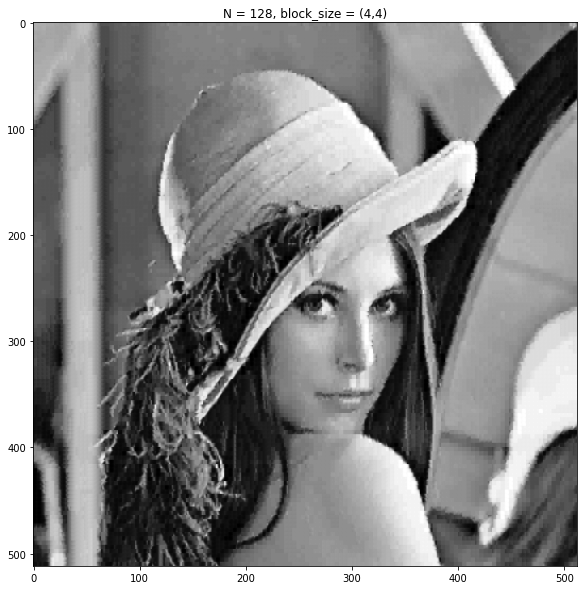

6 / 7  Duration = 115.06153273582458


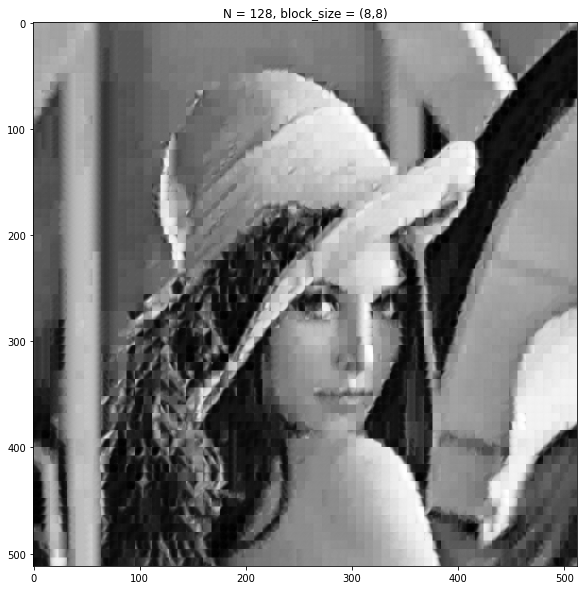

In [16]:
import time

N_array = [2,4,8,16,32,64,128]
block_size_array = [(2,2),(4,4),(8,8)]
time_array = [[],[],[]]

for idx,N in enumerate(N_array):
  for idx2, block_size in enumerate(block_size_array):
    start = time.time()
    codebook_lena = Lloyd_img(lena, N, block_size) #Optimized codebook
    lena_encoded = encode(lena, codebook_lena)
    lena_decoded = decode(lena_encoded, codebook_lena)
    plt.figure(figsize=(10,10))
    plt.imshow(lena_decoded, 'gray')
    plt.title("N = " + str(N) + ", block_size = (" + str(block_size[0]) + "," + str(block_size[1]) + ")")
    end = time.time()
    print(idx, "/", len(N_array), " Duration =", end-start)
    time_array[idx2].append(end-start)
    plt.show()

[[0.7390522956848145, 3.449867010116577, 31.31023120880127, 42.93751764297485, 192.10312581062317, 704.9695405960083, 862.7432029247284], [0.34879088401794434, 1.3394083976745605, 4.518367528915405, 9.18764042854309, 35.947153091430664, 66.17374229431152, 273.6348555088043], [0.15929508209228516, 0.3274679183959961, 2.71490740776062, 2.7211811542510986, 21.467772960662842, 31.232876539230347, 115.06153273582458]]


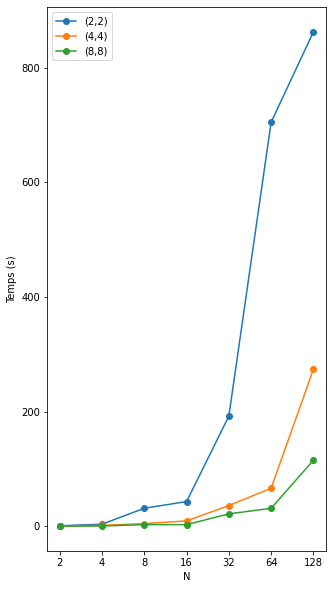

In [36]:
print(time_array)
plt.figure(figsize=(5,10))
for times in time_array:
  plt.plot(range(len(N_array)), times, 'o-')
  plt.legend(["(2,2)","(4,4)","(8,8)"])
  plt.xticks(range(len(N_array)),N_array)
  plt.ylabel("Temps (s)")
  plt.xlabel("N")

In [8]:
def code_decode(img, N, block_size):
  codebook = Lloyd_img(img, N, block_size) #Optimized codebook
  print(codebook)
  img_encoded = encode(img, codebook)
  img_decoded = decode(img_encoded, codebook)
  return img_decoded

{0: array([115.5, 124.5, 120. , 138. ]), 1: array([67. , 64.5, 78. , 78. ])}


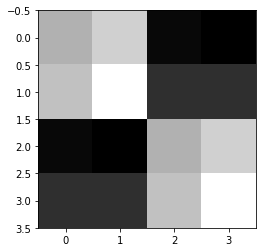

In [50]:
demo4x4 = cv2.imread(path_base + "Demo4x4.png", 0)
plt.imshow(demo4x4, "gray")
plt.imshow(code_decode(demo4x4, 2, (2,2)), "gray")